In [1]:
import pandas as pd
import numpy as np
import math
from decimal import Decimal
from datetime import timedelta
import time
import matplotlib.pyplot as plt

In [2]:
# Load the Parquet file
df_ori = pd.read_parquet('ekubo_market_depth_dataset.parquet')

In [3]:
''' Begin to create aggregated files:
'''
df = df_ori.copy()

# Compute timestamp:
df['datetime'] = pd.to_datetime(df_ori['BLOCK_TIMESTAMP'])
df['timestamp'] = df['datetime'].astype('int64') // 10**9  # Convert nanoseconds to seconds
df = df.sort_values(by='timestamp')
df = df.reset_index(drop=True)

# Obtain names of Token0 and Token1:

# Tag different token address:
# Token0
# ETH: 0x049d36570d4e46f48e99674bd3fcc84644ddd6b96f7c741b1562b82f9e004dc7
# USDC: 0x053c91253bc9682c04929ca02ed00b3e423f6710d2ee7e0d5ebb06f3ecf368a8
# STRK: 0x04718f5a0fc34cc1af16a1cdee98ffb20c31f5cd61d6ab07201858f4287c938d

# Token1
# ETH: 0x049d36570d4e46f48e99674bd3fcc84644ddd6b96f7c741b1562b82f9e004dc7
# USDC: 0x053c91253bc9682c04929ca02ed00b3e423f6710d2ee7e0d5ebb06f3ecf368a8
# USDT: 0x068f5c6a61780768455de69077e07e89787839bf8166decfbf92b645209c0fb8
df['Token0_name'] = ''
df['Token1_name'] = ''

address = '0x049d36570d4e46f48e99674bd3fcc84644ddd6b96f7c741b1562b82f9e004dc7'
df.loc[df['TOKEN0_ADDRESS'] == address, 'Token0_name'] = 'ETH'

address = '0x053c91253bc9682c04929ca02ed00b3e423f6710d2ee7e0d5ebb06f3ecf368a8'
df.loc[df['TOKEN0_ADDRESS'] == address, 'Token0_name'] = 'USDC'

address = '0x04718f5a0fc34cc1af16a1cdee98ffb20c31f5cd61d6ab07201858f4287c938d'
df.loc[df['TOKEN0_ADDRESS'] == address, 'Token0_name'] = 'STRK'

address = '0x049d36570d4e46f48e99674bd3fcc84644ddd6b96f7c741b1562b82f9e004dc7'
df.loc[df['TOKEN1_ADDRESS'] == address, 'Token1_name'] = 'ETH'

address = '0x053c91253bc9682c04929ca02ed00b3e423f6710d2ee7e0d5ebb06f3ecf368a8'
df.loc[df['TOKEN1_ADDRESS'] == address, 'Token1_name'] = 'USDC'

address = '0x068f5c6a61780768455de69077e07e89787839bf8166decfbf92b645209c0fb8'
df.loc[df['TOKEN1_ADDRESS'] == address, 'Token1_name'] = 'USDT'


# Convert each column to either int or float:
columns_int = ['BLOCK_NUMBER', 'TOKEN0_DECIMALS', 'TOKEN1_DECIMALS', 'TICK_SPACING']
df[columns_int] = df[columns_int].applymap(lambda x: int(x))

columns_float = ['TOKEN0_RAW_AMOUNT', 'TOKEN0_REAL_AMOUNT', 'TOKEN1_RAW_AMOUNT', 'TOKEN1_REAL_AMOUNT',
                 'FEE_TIER', 'LIQUIDITY_AMOUNT', 'LOWER_TICK', 'UPPER_TICK', 'SWAP_TICK']
df[columns_float] = df[columns_float].applymap(lambda x: float(x))

# Create a 'tag' column for 'token0_token1'
df['tag'] = df['Token0_name']+'_'+df['Token1_name']

In [13]:
def _generate_aggregation(df2_input, columns_agg, tag, agg_type):
    ''' This is the function to compute and obtain daily aggregations inforamtion. 
    '''
    # Seperate input df to 'mint', 'burn', and 'swap'
    df2_input_mint = df2_input[df2_input['EVENT_NAME']=='Mint']
    df2_input_burn = df2_input[df2_input['EVENT_NAME']=='Burn']
    df2_input_swap = df2_input[df2_input['EVENT_NAME']=='Swap']
    
    # Obtain general daily information
    df2_output = pd.DataFrame(columns=columns_agg, index=[0])
    
    df2_output['tag'] = df2_input['tag'].iloc[0]
    
    if agg_type=='daily':
        df2_output['date'] = pd.Timestamp(df2_input['datetime'].dt.date.iloc[0])
    elif agg_type=='hourly':
        df2_output['date'] = df2_input['datetime'].dt.round('60min').iloc[0]
    
    df2_output['timestamp'] = (df2_output['date'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
    
    df2_output['token0'] = df2_input['Token0_name'].iloc[0]
    df2_output['token1'] = df2_input['Token1_name'].iloc[0]
    
    df2_output['total_events_'+agg_type+'_mint'] = len(df2_input_mint)
    df2_output['total_events_'+agg_type+'_burn'] = len(df2_input_burn)
    df2_output['total_events_'+agg_type+'_swap'] = len(df2_input_swap)
    df2_output['total_events_'+agg_type] = len(df2_input_mint) + len(df2_input_burn) + len(df2_input_swap)

    # Compute 'mint' and 'burn'
    if len(df2_input_mint)>0:
        df2_output_tmp_mint = _compute_agg_price_amount(df2_input_mint, agg_type)
        if len(df2_output_tmp_mint)>0:
            df2_output['token0_'+agg_type+'_price_median_mint']  = df2_output_tmp_mint['price_token0_'+agg_type].iloc[0]
            df2_output['token0_'+agg_type+'_amount_mint'] = df2_output_tmp_mint['amount_token0_'+agg_type].iloc[0]
            df2_output['liquidity_'+agg_type+'_sum_mint'] = df2_output_tmp_mint['liquidity_'+agg_type+'_sum'].iloc[0]
        else:
            df2_output['token0_'+agg_type+'_price_median_mint']  = np.nan
            df2_output['token0_'+agg_type+'_amount_mint'] = 0
            df2_output['liquidity_'+agg_type+'_sum_mint'] = 0            
    else:
        df2_output['token0_'+agg_type+'_price_median_mint']  = np.nan
        df2_output['token0_'+agg_type+'_amount_mint'] = 0
        df2_output['liquidity_'+agg_type+'_sum_mint'] = 0

    if len(df2_input_burn)>0:
        df2_output_tmp_burn = _compute_agg_price_amount(df2_input_burn, agg_type)
        if len(df2_output_tmp_burn)>0:
            df2_output['token0_'+agg_type+'_price_median_burn']  = df2_output_tmp_burn['price_token0_'+agg_type].iloc[0]
            df2_output['token0_'+agg_type+'_amount_burn'] = df2_output_tmp_burn['amount_token0_'+agg_type].iloc[0]
            df2_output['liquidity_'+agg_type+'_sum_burn'] = df2_output_tmp_burn['liquidity_'+agg_type+'_sum'].iloc[0]
        else:
            df2_output['token0_'+agg_type+'_price_median_burn']  = np.nan
            df2_output['token0_'+agg_type+'_amount_burn'] = 0
            df2_output['liquidity_'+agg_type+'_sum_burn'] = 0            
    else:
        df2_output['token0_'+agg_type+'_price_median_burn']  = np.nan
        df2_output['token0_'+agg_type+'_amount_burn'] = 0
        df2_output['liquidity_'+agg_type+'_sum_burn'] = 0

    df2_output['token0_'+agg_type+'_amount_net_mint_burn'] = df2_output['token0_'+agg_type+'_amount_mint'] + df2_output['token0_'+agg_type+'_amount_burn']
    df2_output['liquidity_'+agg_type+'_net_mint_burn'] = df2_output['liquidity_'+agg_type+'_sum_mint'] + df2_output['liquidity_'+agg_type+'_sum_burn']
        
    # Compute 'swap':
    if len(df2_input_swap)>0:
        df2_output_tmp_swap = _compute_agg_price_amount(df2_input_swap, agg_type)
        if len(df2_output_tmp_swap)>0:
            df2_output['token0_'+agg_type+'_price_median_swap'] = abs(df2_output_tmp_swap['ratio_token1_token0'].median())
            df2_output['token0_'+agg_type+'_price_min_swap']  = abs(df2_output_tmp_swap['ratio_token1_token0'].max())  # Note: the swap value will be negative, so need to use max() to obtain a min price
            df2_output['token0_'+agg_type+'_price_max_swap']  = abs(df2_output_tmp_swap['ratio_token1_token0'].min())  # Note: the swap value will be negative, so need to use inx() to obtain a max price
            df2_output['token0_'+agg_type+'_price_std_swap']  = abs(df2_output_tmp_swap['ratio_token1_token0'].std())
        
            df2_output['token0_'+agg_type+'_amount_buy_swap']  = df2_output_tmp_swap['token0_'+agg_type+'_swap_buy'].iloc[0]
            df2_output['token0_'+agg_type+'_amount_sell_swap'] = df2_output_tmp_swap['token0_'+agg_type+'_swap_sell'].iloc[0]
            df2_output['token0_'+agg_type+'_amount_net_swap']  = df2_output['token0_'+agg_type+'_amount_buy_swap'] + df2_output['token0_'+agg_type+'_amount_sell_swap']
            # df_new['token0_daily_volumn_buy_swap_inUSD'] = df_new['token0_daily_price_median_swap'] * df_new['token0_daily_amount_buy_swap']
            # df_new['token0_daily_volumn_sell_swap_inUSD'] = df_new['token0_daily_price_median_swap'] * df_new['token0_daily_amount_sell_swap']
            # df_new['token0_daily_volumn_net_swap_inUSD'] = df_new['token0_daily_volumn_buy_swap_inUSD'] + df_new['token0_daily_volumn_net_swap_inUSD']
        else:
            df2_output['token0_'+agg_type+'_price_median_swap'] = np.nan
            df2_output['token0_'+agg_type+'_price_min_swap']  = np.nan
            df2_output['token0_'+agg_type+'_price_max_swap']  = np.nan
            df2_output['token0_'+agg_type+'_price_std_swap']  = np.nan
            df2_output['token0_'+agg_type+'_amount_buy_swap']  = np.nan
            df2_output['token0_'+agg_type+'_amount_sell_swap'] = np.nan
            df2_output['token0_'+agg_type+'_amount_net_swap']  = np.nan            
    else:
        df2_output['token0_'+agg_type+'_price_median_swap'] = np.nan
        df2_output['token0_'+agg_type+'_price_min_swap']  = np.nan
        df2_output['token0_'+agg_type+'_price_max_swap']  = np.nan
        df2_output['token0_'+agg_type+'_price_std_swap']  = np.nan
        df2_output['token0_'+agg_type+'_amount_buy_swap']  = np.nan
        df2_output['token0_'+agg_type+'_amount_sell_swap'] = np.nan
        df2_output['token0_'+agg_type+'_amount_net_swap']  = np.nan
    # Compute 'LIQUIDITY_AMOUNT' for 'Mint' and 'Burn' only:
    # df_new['liquidity_amount_sum'] = df_day['LIQUIDITY_AMOUNT'].sum()    

    df2_output['liquidity_'+agg_type+'_cum_sum_mint'] = df2_output['liquidity_'+agg_type+'_sum_mint'].cumsum()
    df2_output['liquidity_'+agg_type+'_cum_sum_burn'] = df2_output['liquidity_'+agg_type+'_sum_burn'].cumsum()
    df2_output['liquidity_'+agg_type+'_cum_net_mint_burn'] = df2_output['liquidity_'+agg_type+'_cum_sum_mint'] + df2_output['liquidity_'+agg_type+'_cum_sum_burn']

    df2_output['token0_'+agg_type+'_amount_cum_buy_swap'] = df2_output['token0_'+agg_type+'_amount_buy_swap'].cumsum()
    df2_output['token0_'+agg_type+'_amount_cum_sell_swap'] = df2_output['token0_'+agg_type+'_amount_sell_swap'].cumsum()
    df2_output['token0_'+agg_type+'_amount_cum_net_swap'] = df2_output['token0_'+agg_type+'_amount_net_swap'].cumsum()
    
    df2_output = df2_output.sort_values(by='timestamp')
    df2_output = df2_output.reset_index(drop=True)
    return df2_output
    
###################################################################################################
def _compute_agg_price_amount(df_day_input, agg_type):
    ''' To compute Token0 daily price and amount:
        Method: 
        Individual event price: 'TOKEN1_REAL_AMOUNT' / 'TOKEN0_REAL_AMOUNT'
        The final daily price '''
    df_day_output = pd.DataFrame()
    df_day_output['ratio_token1_token0'] = df_day_input['TOKEN1_REAL_AMOUNT']/df_day_input['TOKEN0_REAL_AMOUNT'] # Compute TOKEN1_REAL_AMOUNT/TOKEN0_REAL_AMOUNT
    df_day_output['TOKEN0_REAL_AMOUNT'] = df_day_input['TOKEN0_REAL_AMOUNT']     
    df_day_output = df_day_output[(df_day_output != 0) & (df_day_output != np.inf) & (df_day_output != -np.inf)].dropna() # Remove rows with 0, inf, or -inf values

    # Below only apply to 'mint' and 'burn'
    if (df_day_input['EVENT_NAME'].iloc[0]=='Mint') | (df_day_input['EVENT_NAME'].iloc[0]=='Burn'):
        # df_day_output['percentage'] = df_day_output['TOKEN0_REAL_AMOUNT']/df_day_output['TOKEN0_REAL_AMOUNT'].sum()
        # df_day_output['price_token0_daily'] = np.sum(df_day_output['ratio_token1_token0']*df_day_output['percentage'])
        df_day_output['price_token0_'+agg_type] = df_day_output['ratio_token1_token0'].median()
        df_day_output['amount_token0_'+agg_type] = df_day_output['TOKEN0_REAL_AMOUNT'].sum()
        df_day_output['liquidity_'+agg_type+'_sum'] = df_day_input['LIQUIDITY_AMOUNT'].sum()

    # Below only apply to 'swap'
    if df_day_input['EVENT_NAME'].iloc[0]=='Swap':
        df_day_output['token0_'+agg_type+'_swap_buy']   = df_day_input[df_day_input['TOKEN0_REAL_AMOUNT']>0]['TOKEN0_REAL_AMOUNT'].sum()
        df_day_output['token0_'+agg_type+'_swap_sell']  = df_day_input[df_day_input['TOKEN0_REAL_AMOUNT']<0]['TOKEN0_REAL_AMOUNT'].sum()
        df_day_output['token0_'+agg_type+'_swap_total'] = df_day_output['token0_'+agg_type+'_swap_buy'] + df_day_output['token0_'+agg_type+'_swap_sell']

    return df_day_output

###################################################################################################
def _generate_datetime_range(df2, agg_type):
    ''' Obatin a list with 'daily' or 'hourly' from the selected dataframe ''' 
    # Obtain the begin and end date of selected dataframe
    dt_begin = df2['datetime'].iloc[0]
    dt_end   = df2['datetime'].iloc[-1]
    d_begin = dt_begin.date()
    d_end   = dt_end.date() + timedelta(days=1)
    if agg_type=='daily':
        datetime_range = pd.date_range(start=d_begin, end=d_end)
    elif agg_type=='hourly':
        datetime_range = pd.date_range(start=d_begin, end=d_end, freq='H')
    return datetime_range
        
###################################################################################################
def create_aggregation_table(df, tags, agg_type):
    # Create an empty dataframe with defaulted column names 
    columns_agg = ['tag', 'token0', 'token1', 
                   'date', 'timestamp', 
                   
                   'token0_'+agg_type+'_price_median_mint', 'token0_'+agg_type+'_amount_mint', 
                   'token0_'+agg_type+'_price_median_burn', 'token0_'+agg_type+'_amount_burn', 
                   'token0_'+agg_type+'_amount_net_mint_burn',
                   
                   'liquidity_'+agg_type+'_sum_mint', 'liquidity_'+agg_type+'_sum_burn', 'liquidity_'+agg_type+'_net_mint_burn',
                   'liquidity_'+agg_type+'_cum_sum_mint', 'liquidity_'+agg_type+'_cum_sum_burn', 'liquidity_'+agg_type+'_cum_net_mint_burn',
                   
                   'token0_'+agg_type+'_price_median_swap', 'token0_'+agg_type+'_price_min_swap', 
                   'token0_'+agg_type+'_price_max_swap', 'token0_'+agg_type+'_price_std_swap',
                   
                   'token0_'+agg_type+'_amount_buy_swap', 'token0_'+agg_type+'_amount_sell_swap', 'token0_'+agg_type+'_amount_net_swap',
                   'token0_'+agg_type+'_amount_cum_buy_swap', 'token0_'+agg_type+'_amount_cum_sell_swap', 'token0_'+agg_type+'_amount_cum_net_swap',
                   # 'token0_daily_volumn_buy_swap_inUSD', 'token0_daily_volumn_sell_swap_inUSD', 'token0_daily_volumn_net_swap_inUSD',
                   
                   'total_events_'+agg_type+'_mint', 'total_events_'+agg_type+'_burn', 'total_events_'+agg_type+'_swap', 'total_events_'+agg_type ]
    df_all = pd.DataFrame(columns=columns_agg)
    
    for tag in tags:
        print('Computing aggregation data for '+agg_type, tag)
        # Select data type: e.g., STRK_USDC_Mint, ETH_USDC_Burn, STRK_ETH_Swap, ... etc
        df2 = df[df['tag']==tag]
        df_agg_tmp = pd.DataFrame(columns=columns_agg)   # create a temporal dataframe

        # First, seperate into daily dataframe
        datetime_range = _generate_datetime_range(df2, agg_type)  # create either daily or hourly agg data
        
        for dt in datetime_range:
            if agg_type == 'daily':
                # Select data within a certain day
                df2_input = df2[df2['datetime'].dt.date == dt.date()] 
            elif agg_type == 'hourly':
                # Select data within a certain hour of a certain day
                df2_input = df2[ (df2['datetime'].dt.date == dt.date()) & (df2['datetime'].dt.hour == dt.hour) ]   
                
            if len(df2_input)>0:
                df_new = _generate_aggregation(df2_input, columns_agg, tag, agg_type)   # Compute aggregation values
                df_agg_tmp = pd.concat([df_agg_tmp, df_new])
                df_agg_tmp = df_agg_tmp.reset_index(drop=True)
    
        df_all = pd.concat([df_all, df_agg_tmp])
        
    df_all = df_all.sort_values(by='timestamp')
    df_all = df_all.reset_index(drop=True)
    
    df_all.to_csv('df_agg_'+agg_type+'_all.csv', index=False)
    print('Saved to ', 'df_agg_'+agg_type+'_all.csv')
    print('End of Computing')

In [14]:
# Compute daily aggregation data
tags_daily = df['tag'].unique()
print(tags_daily)
start_time = time.time()
#######
create_aggregation_table(df, tags_daily, 'daily')
#######
end_time = time.time()
print("Total execution time:", round((end_time - start_time)/60, 2), "minutes")


# Compute hourly aggregation data
tags_hourly = ['STRK_ETH', 'STRK_USDC', 'STRK_USDT']
# tags_hourly = tags_daily
print(tags_hourly)  

start_time = time.time()
#######
create_aggregation_table(df, tags_hourly, 'hourly')
#######
end_time = time.time()
print("Total execution time:", round((end_time - start_time)/60, 2), "minutes")

['ETH_USDC' 'USDC_USDT' 'STRK_ETH' 'STRK_USDC' 'STRK_USDT']
Computing aggregation data for daily ETH_USDC
Computing aggregation data for daily USDC_USDT
Computing aggregation data for daily STRK_ETH
Computing aggregation data for daily STRK_USDC
Computing aggregation data for daily STRK_USDT
Saved to  df_agg_daily_all.csv
End of Computing
Total execution time: 2.64 minutes
['STRK_ETH', 'STRK_USDC', 'STRK_USDT']
Computing aggregation data for hourly STRK_ETH
Computing aggregation data for hourly STRK_USDC
Computing aggregation data for hourly STRK_USDT
Saved to  df_agg_hourly_all.csv
End of Computing
Total execution time: 0.65 minutes


In [21]:
# Save individual files for ETH/USDC, USDC/USDT, STRK/ETH, STRK/USDC, STRK/USDT
tags_daily = ['ETH_USDC', 'USDC_USDT', 'STRK_ETH', 'STRK_USDC', 'STRK_USDT']
for tag in tags_daily:
    df_daily = pd.read_csv('df_agg_daily_all.csv')
    dfn = df_daily[df_daily['tag']==tag]
    dfn.reset_index(drop=True, inplace=True)
    dfn.to_csv('df_agg_daily_'+tag+'.csv', index=False)
    print('Saved to ', 'df_agg_daily_'+tag+'.csv')

tags_hourly = ['STRK_ETH', 'STRK_USDC', 'STRK_USDT']
for tag in tags_hourly:
    df_hourly = pd.read_csv('df_agg_hourly_all.csv')
    dfn = df_hourly[df_hourly['tag']==tag]
    dfn.reset_index(drop=True, inplace=True)
    dfn.to_csv('df_agg_hourly_'+tag+'.csv', index=False)
    print('Saved to ', 'df_agg_hourly_'+tag+'.csv')

Saved to  df_agg_daily_ETH_USDC.csv
Saved to  df_agg_daily_USDC_USDT.csv
Saved to  df_agg_daily_STRK_ETH.csv
Saved to  df_agg_daily_STRK_USDC.csv
Saved to  df_agg_daily_STRK_USDT.csv
Saved to  df_agg_hourly_STRK_ETH.csv
Saved to  df_agg_hourly_STRK_USDC.csv
Saved to  df_agg_hourly_STRK_USDT.csv


In [22]:
df_ETH_USDC = pd.read_csv('df_agg_daily_ETH_USDC.csv')
df_ETH_USDC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187 entries, 0 to 186
Data columns (total 30 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   tag                                187 non-null    object 
 1   token0                             187 non-null    object 
 2   token1                             187 non-null    object 
 3   date                               187 non-null    object 
 4   timestamp                          187 non-null    int64  
 5   token0_daily_price_median_mint     186 non-null    float64
 6   token0_daily_amount_mint           187 non-null    float64
 7   token0_daily_price_median_burn     182 non-null    float64
 8   token0_daily_amount_burn           187 non-null    float64
 9   token0_daily_amount_net_mint_burn  187 non-null    float64
 10  liquidity_daily_sum_mint           187 non-null    float64
 11  liquidity_daily_sum_burn           187 non-null    float64

In [23]:
df_ETH_USDC.iloc[22]

tag                                            ETH_USDC
token0                                              ETH
token1                                             USDC
date                                         2023-09-14
timestamp                                    1694649600
token0_daily_price_median_mint              1689.320632
token0_daily_amount_mint                     -12.798675
token0_daily_price_median_burn              1689.320586
token0_daily_amount_burn                       0.456841
token0_daily_amount_net_mint_burn            -12.341834
liquidity_daily_sum_mint             9630181268773528.0
liquidity_daily_sum_burn             -324302866910177.0
liquidity_daily_net_mint_burn        9305878401863352.0
liquidity_daily_cum_sum_mint         9630181268773528.0
liquidity_daily_cum_sum_burn         -324302866910177.0
liquidity_daily_cum_net_mint_burn    9305878401863352.0
token0_daily_price_median_swap              1629.834986
token0_daily_price_min_swap                 1292

In [17]:
df_STRK_USDC = pd.read_csv('df_agg_hourly_STRK_USDT.csv')
df_STRK_USDC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116 entries, 0 to 115
Data columns (total 30 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   tag                                 116 non-null    object 
 1   token0                              116 non-null    object 
 2   token1                              116 non-null    object 
 3   date                                116 non-null    object 
 4   timestamp                           116 non-null    int64  
 5   token0_hourly_price_median_mint     52 non-null     float64
 6   token0_hourly_amount_mint           116 non-null    float64
 7   token0_hourly_price_median_burn     30 non-null     float64
 8   token0_hourly_amount_burn           116 non-null    float64
 9   token0_hourly_amount_net_mint_burn  116 non-null    float64
 10  liquidity_hourly_sum_mint           116 non-null    float64
 11  liquidity_hourly_sum_burn           116 non-n

In [18]:
df_STRK_USDC.iloc[20]

tag                                             STRK_USDT
token0                                               STRK
token1                                               USDT
date                                  2024-02-21 04:00:00
timestamp                                      1708488000
token0_hourly_price_median_mint                  1.088868
token0_hourly_amount_mint                     -669.999992
token0_hourly_price_median_burn                  0.873554
token0_hourly_amount_burn                      668.965387
token0_hourly_amount_net_mint_burn              -1.034605
liquidity_hourly_sum_mint              8064173731709594.0
liquidity_hourly_sum_burn             -2013564270332200.0
liquidity_hourly_net_mint_burn         6050609461377393.0
liquidity_hourly_cum_sum_mint          8064173731709594.0
liquidity_hourly_cum_sum_burn         -2013564270332200.0
liquidity_hourly_cum_net_mint_burn     6050609461377393.0
token0_hourly_price_median_swap                  2.038196
token0_hourly_

In [19]:
df_ETH_USDC.columns

Index(['tag', 'token0', 'token1', 'date', 'timestamp',
       'token0_daily_price_median_mint', 'token0_daily_amount_mint',
       'token0_daily_price_median_burn', 'token0_daily_amount_burn',
       'token0_daily_amount_net_mint_burn', 'liquidity_daily_sum_mint',
       'liquidity_daily_sum_burn', 'liquidity_daily_net_mint_burn',
       'liquidity_daily_cum_sum_mint', 'liquidity_daily_cum_sum_burn',
       'liquidity_daily_cum_net_mint_burn', 'token0_daily_price_median_swap',
       'token0_daily_price_min_swap', 'token0_daily_price_max_swap',
       'token0_daily_price_std_swap', 'token0_daily_amount_buy_swap',
       'token0_daily_amount_sell_swap', 'token0_daily_amount_net_swap',
       'token0_daily_amount_cum_buy_swap', 'token0_daily_amount_cum_sell_swap',
       'token0_daily_amount_cum_net_swap', 'total_events_daily_mint',
       'total_events_daily_burn', 'total_events_daily_swap',
       'total_events_daily'],
      dtype='object')

### Comparision between the ETH/USDC prices computed from this study vs ETH/USD prices downloaded from public datasets  

In [25]:
import pycoingecko
import datetime

# Download ETH Data
coinGecko = pycoingecko.CoinGeckoAPI()  # Initialize CoinGecko API client
eth_data = coinGecko.get_coin_market_chart_by_id('ethereum', 'usd', '365days')  # Get historical price data for ETH
# keys: 'prices', 'market_caps', 'total_volumes'
_dates = [data[0] for data in eth_data['prices']] 
dates = [ datetime.datetime.fromtimestamp(date/1000) for date in _dates ] # convert unix timestamp to datetime
prices = [data[1] for data in eth_data['prices']]
# # Plot the data
# plt.plot(dates, prices)

In [26]:
# Load daily aggregatrions file:
df = pd.read_csv('df_agg_daily_ETH_USDC.csv')

# Get df for ETH/USDC, USDC/USDT, STRK/USDC, STRK/ETH 
df_ETH_USDC  = df[df['tag']=='ETH_USDC']
df_USDC_USDT = df[df['tag']=='USDC_USDT']
df_STRK_USDC = df[df['tag']=='STRK_USDC']
df_STRK_ETH  = df[df['tag']=='STRK_ETH']

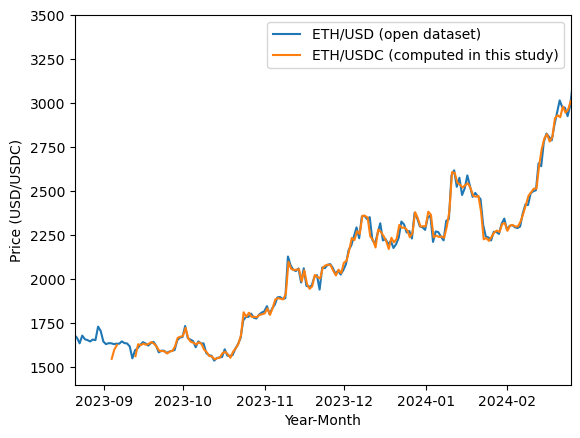

In [28]:
dfn = df_ETH_USDC
dfn['date'] = pd.to_datetime(df['date'])

plt.plot(dates, prices, label='ETH/USD (open dataset)')
plt.plot(dfn['date'], dfn['token0_daily_price_median_swap'], label='ETH/USDC (computed in this study)')
plt.xlim(dfn['date'].iloc[0], dfn['date'].iloc[-1])
plt.ylim(1400, 3500)
plt.ylabel('Price (USD/USDC)')
plt.xlabel('Year-Month')
plt.legend()

plt.savefig('images/fig_01b_01_ETH_price_comparison.png', dpi=150)